# 탐색적 데이터 분석 결과

**설명 파일 :** [03_탐색적데이터분석.md](03_탐색적데이터분석.md)

## Step 1. 사전 설정

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.express as px
import os
import warnings

# 파일 위치 사전 정의
warnings.filterwarnings("ignore")

SAMPLING_DATA_DIR = './data/external'

# 한글 폰트 설정
fe = fm.FontEntry(
fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False

print("모듈 import 완료")

모듈 import 완료


## Step 2. 시계열 분석

In [223]:
# 불러올 데이터 파일들
data_files = {
    'sampled_2022.csv',
    'sampled_2023.csv',
    'sampled_2024.csv',
    'sampled_2025.csv'
}

# 데이터 타입 맵
dtypes = {
    'admi_cty_no': 'int64', 
    'card_tpbuz_cd': 'category', 
    'age': 'int8', 
    'sex': 'category', 
    'ta_ymd': 'int64',
    'amt': 'int32', 
    'cnt': 'int16',
    'day': 'int8',
    'hour': 'int8'
}

# 행안부 기준 지역 목록 맵
region_map = {
    41110: '수원시', 41111: '수원시', 41113: '수원시', 41115: '수원시', 41117: '수원시', # 수원 통합
    41190: '부천시', 41191: '부천시', 41193: '부천시', # 부천 통합
    41210: '광명시',
    41270: '안산시', 41271: '안산시', 41273: '안산시', # 안산 통합
    41170: '안양시', 41171: '안양시', 41173: '안양시', # 안양 통합
    41390: '시흥시',
    41460: '용인시', 41461: '용인시', 41463: '용인시', 41465: '용인시', # 용인 통합
    41650: '포천시',
    41450: '하남시',
    41590: '화성시'
}

# 요일 맵
day_map = {1: '일', 2: '월', 3: '화', 4: '수', 5: '목', 6: '금', 7: '토'}
day_order = ['월', '화', '수', '목', '금', '토', '일']

# 시간대 맵
hour_map = {
    1: '새벽',   # 00:00-07:00 (새벽)
    2: '아침',   # 07:00-09:00 (아침)
    3: '오전',   # 09:00-11:00 (오전)
    4: '점심',   # 11:00-13:00 (점심)
    5: '오후초', # 13:00-15:00 (오후초)
    6: '오후',   # 15:00-17:00 (오후)
    7: '저녁',   # 17:00-19:00 (저녁)
    8: '밤',     # 19:00-21:00 (밤)
    9: '늦은밤', # 21:00-23:00 (늦은밤)
    10: '심야'   # 23:00-24:00 (심야)
}
hour_order = ['새벽', '아침', '오전', '점심', '오후초', '오후', '저녁', '밤', '늦은밤', '심야']

# 연령대 맵
age_map = {
    1: '0-9세', 2: '10-19세', 3: '20-29세', 4: '30-39세', 5: '40-49세',
    6: '50-59세', 7: '60-69세', 8: '70-79세', 9: '80-89세', 10: '90-99세', 11: '100세이상'
}
age_order = ['0-9세', '10-19세', '20-29세', '30-39세', '40-49세', '50-59세', '60-69세', '70-79세', '80-89세', '90-99세', '100세이상']

In [224]:
# 1. 데이터 로드 (연도별 파일 모두 읽기)

dfs = []

for f in data_files:
    path = os.path.join(SAMPLING_DATA_DIR, f)
    if os.path.exists(path):
        df_temp = pd.read_csv(path, dtype=dtypes, usecols=list(dtypes.keys()))

        df_temp['city'] = (df_temp['admi_cty_no'] // 1000).map(region_map)
        df_temp = df_temp.dropna(subset=['city']).copy()

        df_temp['date'] = pd.to_datetime(df_temp['ta_ymd'], format='%Y%m%d')
        df_temp['year'] = df_temp['date'].dt.year
        df_temp['month'] = df_temp['date'].dt.month

        df_temp['day'] = df_temp['day'].map(day_map)
        df_temp['hour'] = df_temp['hour'].map(hour_map)

        df_temp['age'] = df_temp['age'].map(age_map)

        dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)


In [225]:
df.head()

,ta_ymd,admi_cty_no,card_tpbuz_cd,hour,sex,age,day,amt,cnt,city,date,year,month
0,20250105,41390550,F09,밤,F,30-39세,토,361621,8,시흥시,2025-01-05,2025,1
1,20250129,41590259,Q06,오전,M,40-49세,화,16427,2,화성시,2025-01-29,2025,1
2,20250123,41171510,D03,오후,M,50-59세,수,2139,2,안양시,2025-01-23,2025,1
3,20250123,41590253,Q11,오전,F,40-49세,수,222278,21,화성시,2025-01-23,2025,1
4,20250128,41210550,Q10,밤,M,50-59세,월,623080,8,광명시,2025-01-28,2025,1


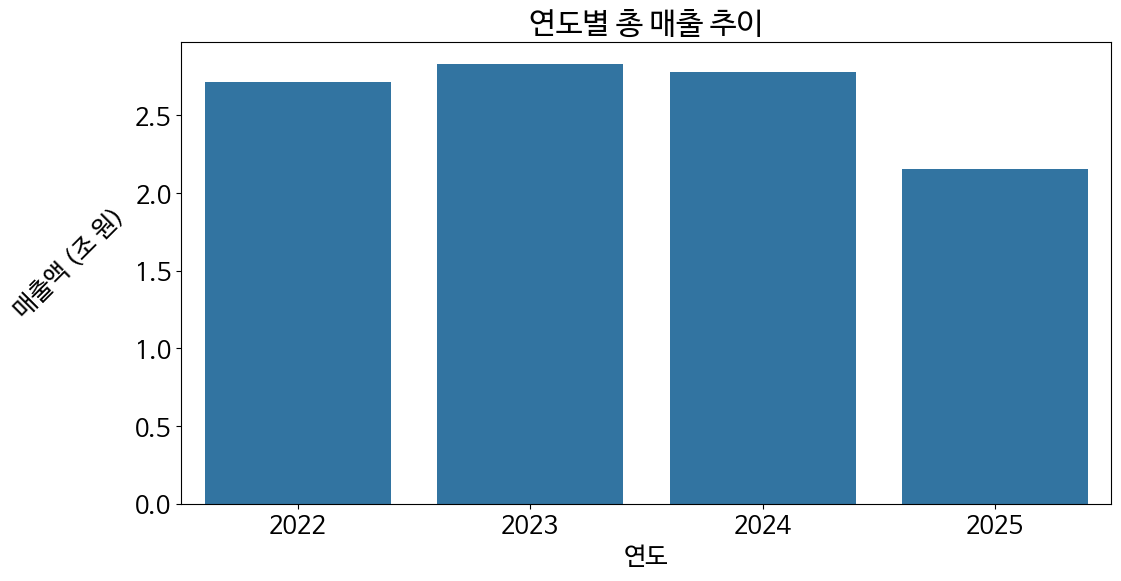

In [226]:
# [시각화 1] 연도별 매출 추이
yearly = df.groupby('year')['amt'].sum().reset_index()

yearly['amt_tril'] = yearly['amt'] / 1e12 

plt.figure(figsize=(12, 6))
sns.barplot(data=yearly, x='year', y='amt_tril')
plt.title('연도별 총 매출 추이')
plt.xlabel('연도')
plt.ylabel('매출액 (조 원)', rotation=45, labelpad=40) 
plt.show()

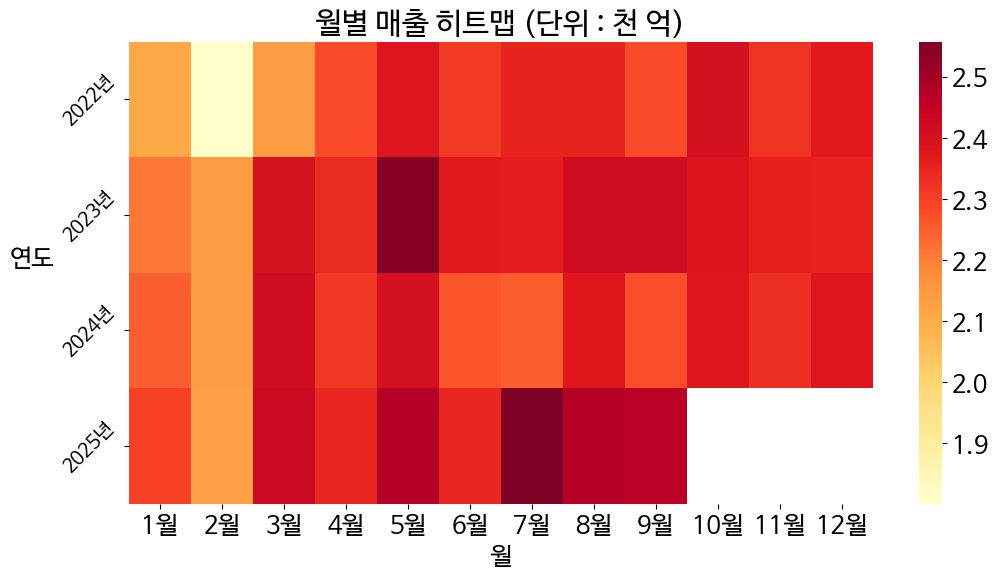

In [227]:
# [시각화 2] 월별 계절성 (히트맵)
seasonal = df.groupby(['year', 'month'])['amt'].sum().reset_index()
seasonal['amt_100bil'] = seasonal['amt'] / 1e11 
pivot = seasonal.pivot(index='year', columns='month', values='amt_100bil')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='YlOrRd', xticklabels=[f'{m}월' for m in pivot.columns], yticklabels=[f'{y}년' for y in pivot.index])
plt.title('월별 매출 히트맵 (단위 : 천 억)')
plt.xlabel('월')
plt.ylabel('연도', rotation=0, labelpad=20) 
plt.yticks(fontsize=14, rotation=45, ha='right')
plt.show()

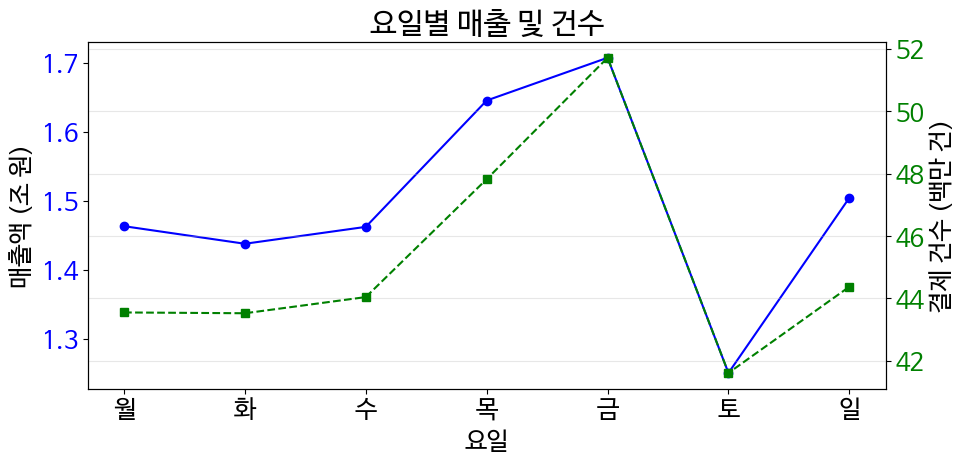

In [228]:
# [시각화 3] 요일별 패턴
daily = df.groupby('day')[['amt', 'cnt']].sum()
daily = daily.reindex(day_order)
x = daily.index

daily['amt_tril'] = daily['amt'] / 1e12 
daily['cnt_mil'] = daily['cnt'] / 1e6  

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(x, daily['amt_tril'], color='blue', marker='o', label='매출액')
ax1.set_xlabel('요일')
ax1.set_ylabel('매출액 (조 원)')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(x, daily['cnt_mil'], color='green', linestyle='--', marker='s', label='건수')
ax2.set_ylabel('결제 건수 (백만 건)')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('요일별 매출 및 건수')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

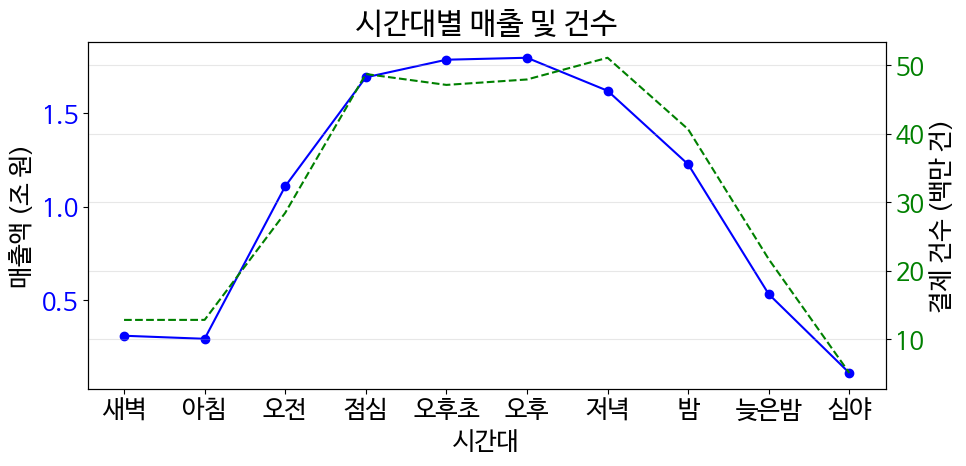

In [229]:
# [시각화 4] 시간대별 패턴
hourly = df.groupby('hour')[['amt', 'cnt']].sum()
hourly = hourly.reindex(hour_order)
x = hourly.index

hourly['amt_tril'] = hourly['amt'] / 1e12 
hourly['cnt_mil'] = hourly['cnt'] / 1e6  

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(x, hourly['amt_tril'], color='blue', marker='o', label='매출')
ax1.set_xlabel('시간대')
ax1.set_ylabel('매출액 (조 원)')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(x, hourly['cnt_mil'], color='green', linestyle='--', label='건수')
ax2.set_ylabel('결제 건수 (백만 건)')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('시간대별 매출 및 건수')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

분석 포인트

- 연도별 성장 : 2022년 대비 2024년 매출 상승 (코로나 엔데믹 효과 확인)
- 계절성 확인 : 연말, 가정의 달, 휴가철 등과 다른 달 매출 비교
- 요일별 확인 : 주말 매출과 평일 매출 비교
- 시간대 확인 : 점심, 저녁과 평시 매출 비교


## Step 3. 인구통계적 분석

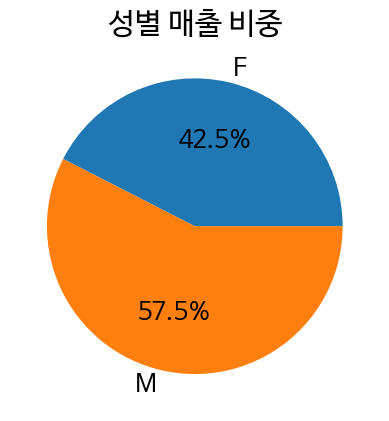

In [59]:
# 현재의 인구를 기준으로 분석할 것이기 때문에 2025년 데이터를 따로 불러온다.
df_2025 = pd.read_csv('data/external/sampled_2025.csv', usecols=['age', 'sex', 'amt', 'cnt', 'card_tpbuz_cd'])
df_2025['age'] = df_2025['age'].map(age_map)

# 1. 성별 매출 비중
sex_amt = df_2025.groupby('sex')['amt'].sum()
plt.pie(sex_amt, labels=sex_amt.index, autopct='%.1f%%')
plt.title('성별 매출 비중')
plt.show()

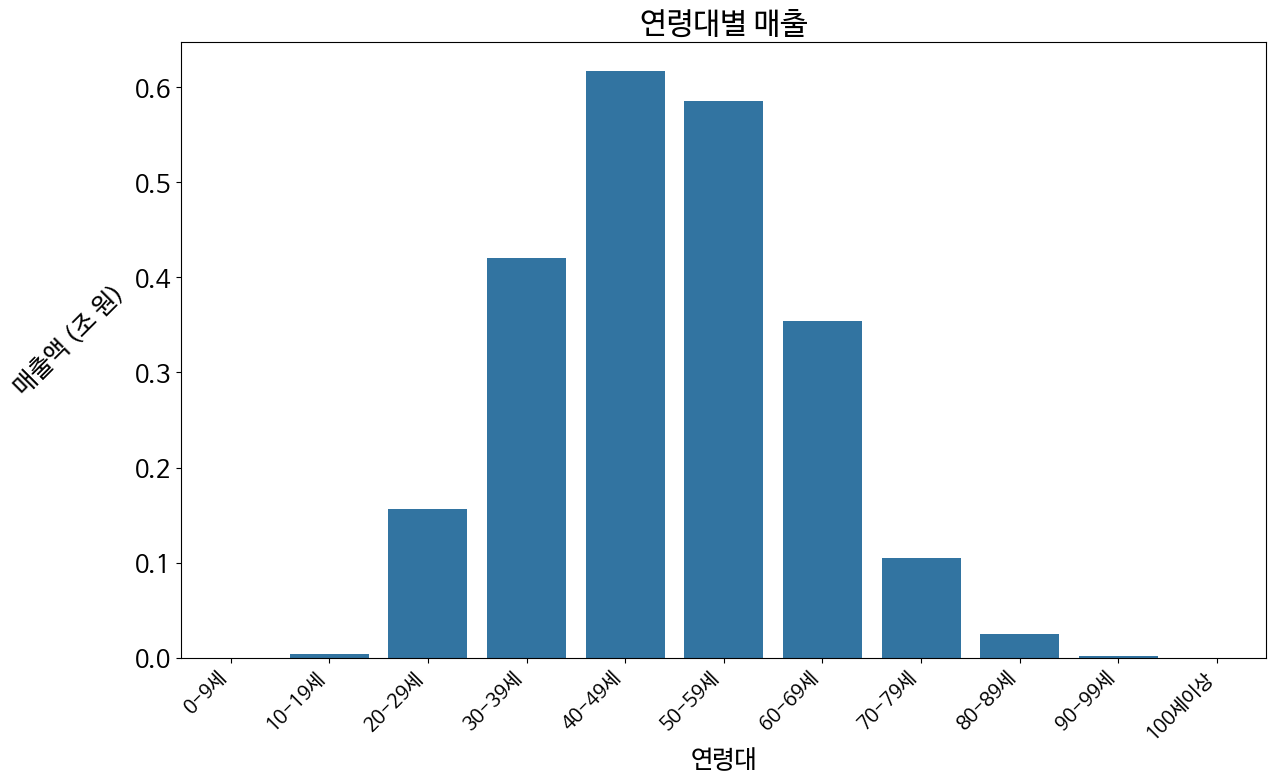

In [199]:
# 2. 연령대별 매출
age_amt = df_2025.groupby('age')['amt'].sum().reset_index()
age_amt['age'] = pd.Categorical(age_amt['age'], categories=age_order, ordered=True)
age_amt = age_amt.sort_values('age').reset_index(drop=True)

age_amt['amt_tril'] = age_amt['amt'] / 1e12 
plt.figure(figsize=(14, 8))
sns.barplot(data=age_amt, x='age', y='amt_tril')
plt.title('연령대별 매출')
plt.xlabel('연령대')
plt.ylabel('매출액 (조 원)', rotation=45, labelpad=40) 
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.show()

In [79]:
# 3. 객단가 분석

# 이 그래프에서 이상 데이터로 볼 수 있는 부분이 있어서 처리
# S03(일반병원)에서 2회에 걸쳐 총 2093042원 결제
kid_df = df_2025[df_2025['age'] == age_order[0]]
kid_df['객단가'] = kid_df['amt'] / kid_df['cnt']
kid_male = kid_df[kid_df['sex'] == 'M']

stats = kid_df.groupby('sex')['객단가'].agg(['mean', 'median', 'count'])
print(stats)

top_biz = kid_male.groupby('card_tpbuz_cd')['amt'].sum().nlargest(5)
print("매출 주도 업종:\n", top_biz)

top_trans = kid_male.nlargest(5, '객단가')
print("최고액 거래 내역:\n", top_trans)


             mean  median  count
sex                             
F     3444.260870  2065.5     23
M    72890.147059  6513.5     17
매출 주도 업종:
 card_tpbuz_cd
S03    2093042
D11     198358
Q02      99786
F09      93240
Q05      32074
Name: amt, dtype: int64
최고액 거래 내역:
         card_tpbuz_cd sex   age      amt  cnt        객단가
925323            S03   M  0-9세  2093042    2  1046521.0
649843            Q02   M  0-9세    99786    2    49893.0
1021318           F09   M  0-9세    93240    2    46620.0
831593            D11   M  0-9세   118966    4    29741.5
2202465           D11   M  0-9세    19430    2     9715.0


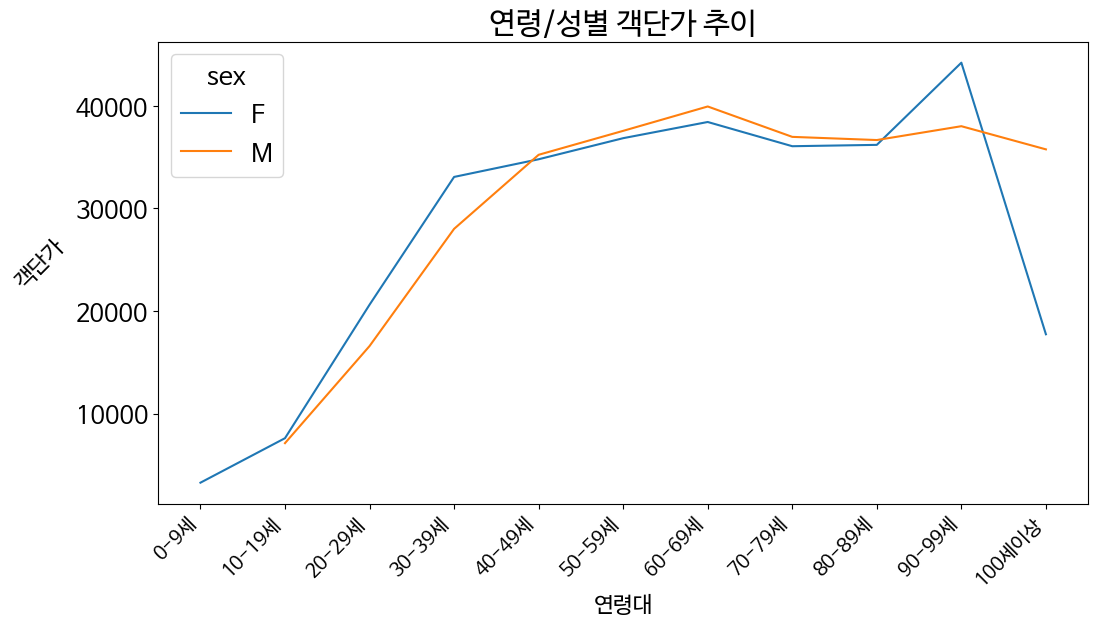

In [202]:
df_agg = df_2025.groupby(['age', 'sex'])[['amt', 'cnt']].sum().reset_index()
df_agg['객단가'] = df_agg['amt'] / df_agg['cnt']
mask_outlier = (df_agg['age'] == age_order[0]) & (df_agg['amt'] / df_agg['cnt'] >= 50000)

df_clean = df_agg[~mask_outlier].copy()
df_clean['age'] = pd.Categorical(df_clean['age'], categories=age_order, ordered=True)
df_clean = df_clean.sort_values('age').reset_index(drop=True)

# 그래프 그리기
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_clean, x='age', y='객단가', hue='sex')
plt.title('연령/성별 객단가 추이')
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.xlabel('연령대', fontsize=16)
plt.ylabel('객단가', fontsize=16, rotation=45, labelpad=20)
plt.show()

분석 포인트

- 핵심 소비층 : 매출 총액이 가장 큰 연령대
- 미래 소비층 : 2030세대의 비중
- 남성 여성의 소비 패턴 차이
- 1회 결제금액이 가장 높은 집단

## Step 4. 카테고리 분석

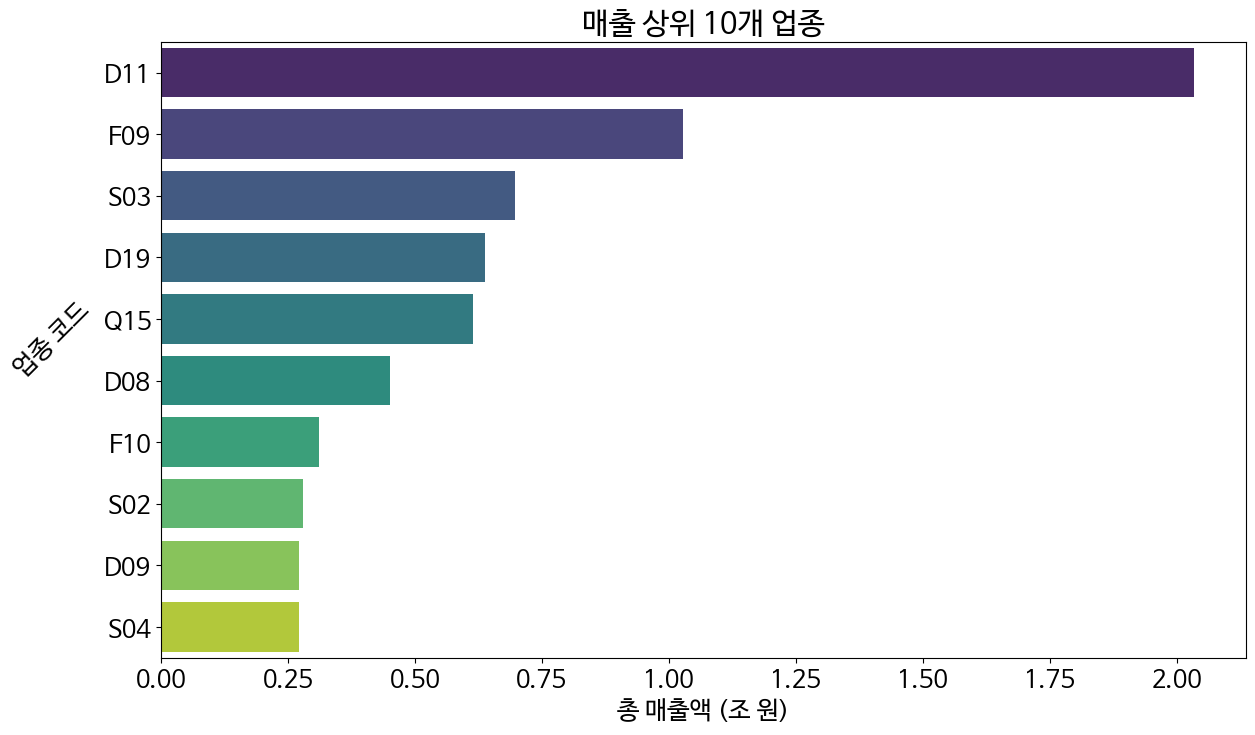

In [230]:
# 1. 매출 규모 Top 10 업종

amt_top10 = df.groupby('card_tpbuz_cd', observed=True)['amt'].sum().nlargest(10).reset_index()
amt_top10['card_tpbuz_cd'] = amt_top10['card_tpbuz_cd'].astype(str)
amt_top10['amt_tril'] = amt_top10['amt'] / 1e12 

plt.figure(figsize=(14, 8))
sns.barplot(data=amt_top10, x='amt_tril', y='card_tpbuz_cd', palette='viridis')
plt.title('매출 상위 10개 업종')
plt.xlabel('총 매출액 (조 원)')
plt.ylabel('업종 코드', rotation=45, labelpad=30)
plt.show()

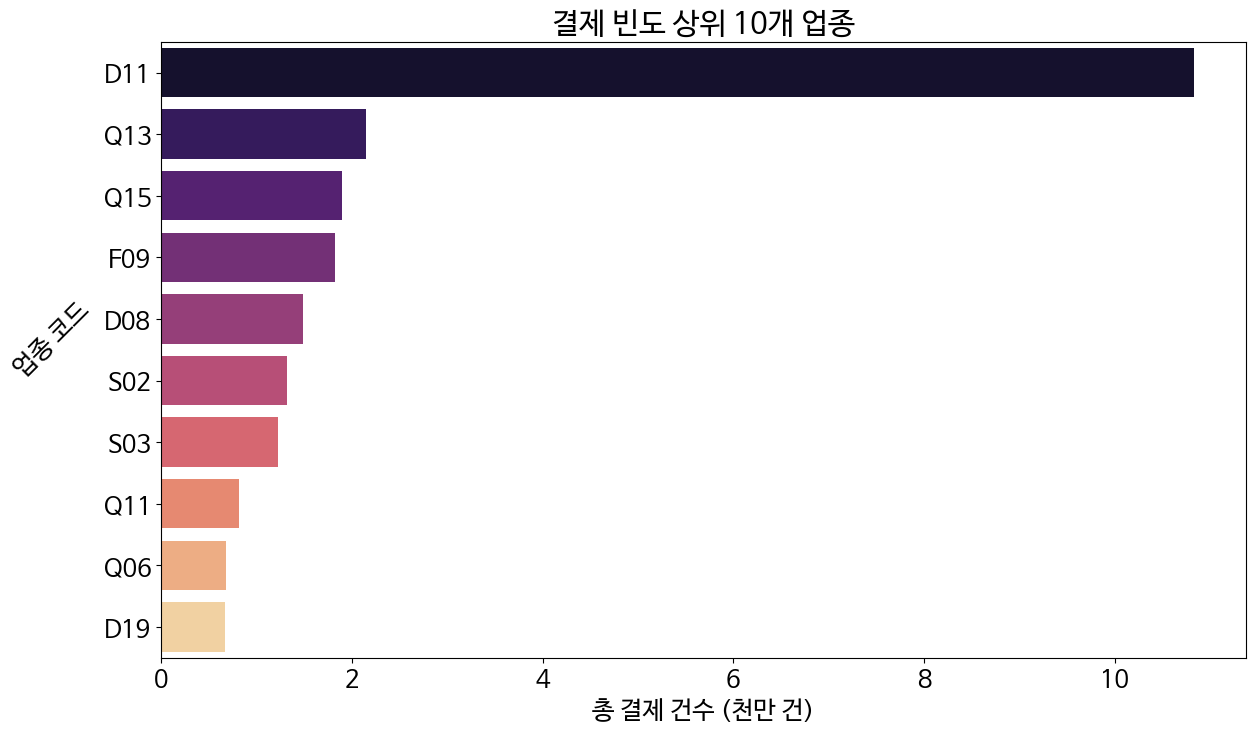

In [231]:
# 2. 결제 빈도 Top 10 업종"
cnt_top10 = df.groupby('card_tpbuz_cd', observed=True)['cnt'].sum().nlargest(10).reset_index()
cnt_top10['card_tpbuz_cd'] = cnt_top10['card_tpbuz_cd'].astype(str)
cnt_top10['cnt_10mil'] = cnt_top10['cnt'] / 1e7 


plt.figure(figsize=(14, 8))
sns.barplot(data=cnt_top10, x='cnt_10mil', y='card_tpbuz_cd', palette='magma')
plt.title('결제 빈도 상위 10개 업종')
plt.xlabel('총 결제 건수 (천만 건)')
plt.ylabel('업종 코드', rotation=45, labelpad=30)
plt.show()

In [232]:
# 3. 업종별 객단가 분석
biz_stats = df.groupby('card_tpbuz_cd', observed=True).agg(total_amt=('amt', 'sum'),total_cnt=('cnt', 'sum')).reset_index()
biz_stats['avg_price'] = biz_stats['total_amt'] / biz_stats['total_cnt']
top_30_biz = biz_stats.nlargest(30, 'total_amt')
top_30_biz['amt_tril'] = top_30_biz['total_amt'] / 1e12 
top_30_biz['cnt_10mil'] = top_30_biz['total_cnt'] / 1e7 


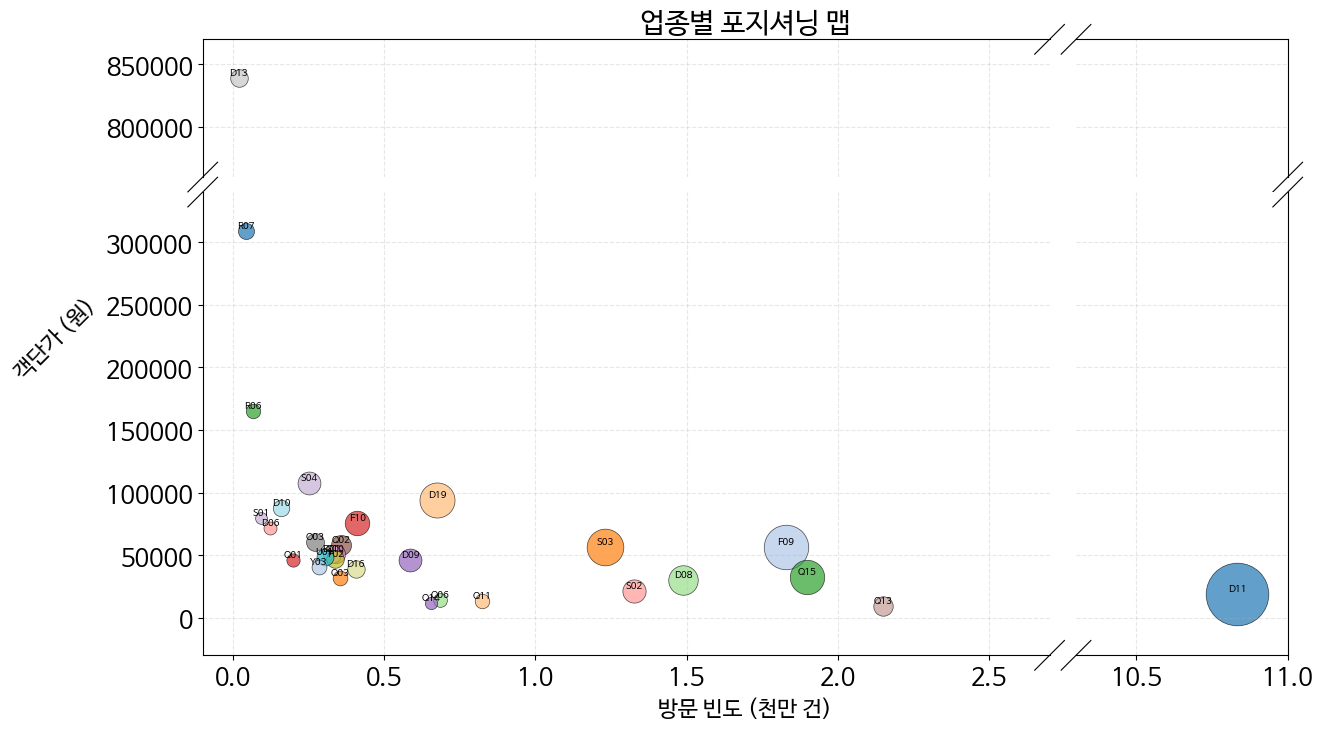

In [233]:
# 그래프를 시각적으로 개선하기 위해 brokenaxes 라이브러리를 사용한다.
# https://github.com/bendichter/brokenaxes

# 축을 생략해서 빈 공간을 줄임.
from brokenaxes import brokenaxes

fig = plt.figure(figsize=(14, 8))

# brokenaxes 객체가 matplotlib의 객체와 호환이 잘 되지 않아서 자체 메서드 사용.
bax = brokenaxes(
    xlims=((-0.1, 2.7), (10.3, 11)), 
    ylims=((-30000, 340000), (760000, 870000)),
    hspace=0.05, wspace=0.05,
    despine=False
)

unique_cats = top_30_biz['card_tpbuz_cd'].unique()
colors = sns.color_palette('tab20', len(unique_cats))
color_map = dict(zip(unique_cats, colors))

for _, row in top_30_biz.iterrows():
    bax.scatter(
        x=row['cnt_10mil'], 
        y=row['avg_price'], 
        s=row['amt_tril'] * 1000,
        color=color_map[row['card_tpbuz_cd']],
        alpha=0.7,
        edgecolor='black',
        linewidth=0.5
    )
    
    bax.text(
        x=row['cnt_10mil'], 
        y=row['avg_price'], 
        s=row['card_tpbuz_cd'],
        fontsize=7,
        ha='center', 
        va='bottom'
    )

bax.set_xlabel('방문 빈도 (천만 건)', fontsize=16, labelpad=30)
bax.set_ylabel('객단가 (원)', fontsize=16, labelpad=100, rotation=45)
bax.grid(True, alpha=0.3, linestyle='--')
bax.set_title('업종별 포지셔닝 맵', fontsize=20)

plt.show()

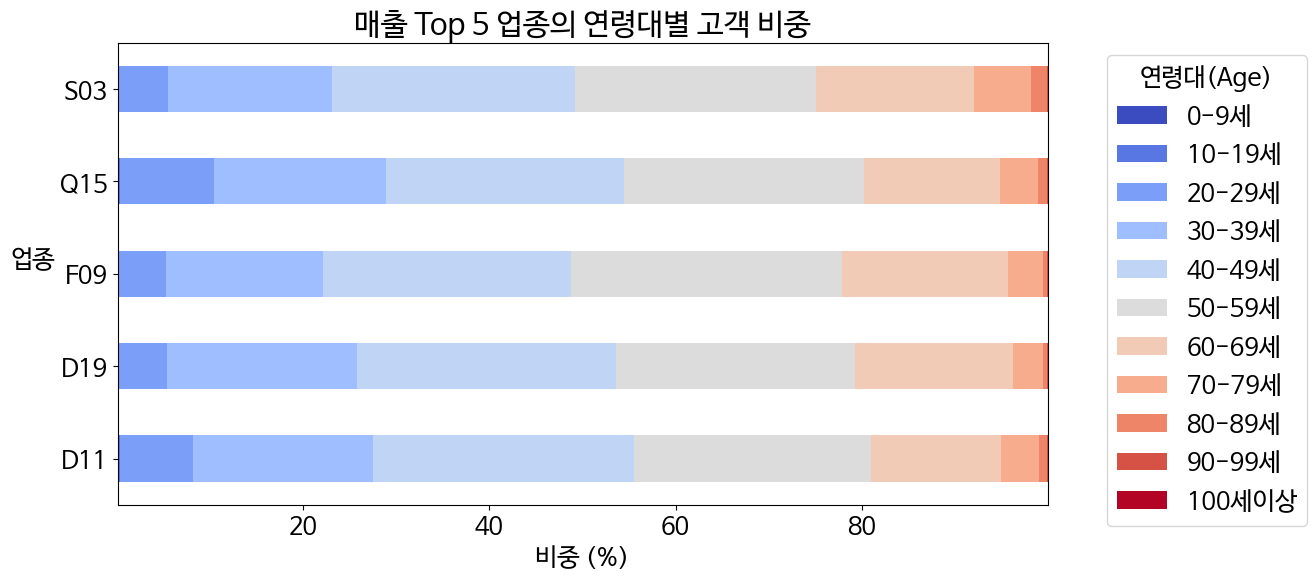

In [234]:
# 4. 업종별 주력 고객층
top_5_names = amt_top10['card_tpbuz_cd'][:5]
subset = df[df['card_tpbuz_cd'].isin(top_5_names)]

subset['amt_tril'] = subset['amt'] / 1e12 

age_biz_pivot = subset.groupby(['card_tpbuz_cd', 'age'], observed=True)['amt_tril'].sum().unstack()
age_biz_pivot = age_biz_pivot.reindex(columns=age_order)

age_biz_ratio = age_biz_pivot.div(age_biz_pivot.sum(axis=1), axis=0) * 100
age_biz_ratio.plot(kind='barh', stacked=True, figsize=(12, 6), colormap='coolwarm')

plt.title('매출 Top 5 업종의 연령대별 고객 비중')
plt.xlabel('비중 (%)')
plt.ylabel('업종', rotation=0, labelpad=20)
plt.legend(title='연령대(Age)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Step 5. 지역별 분석

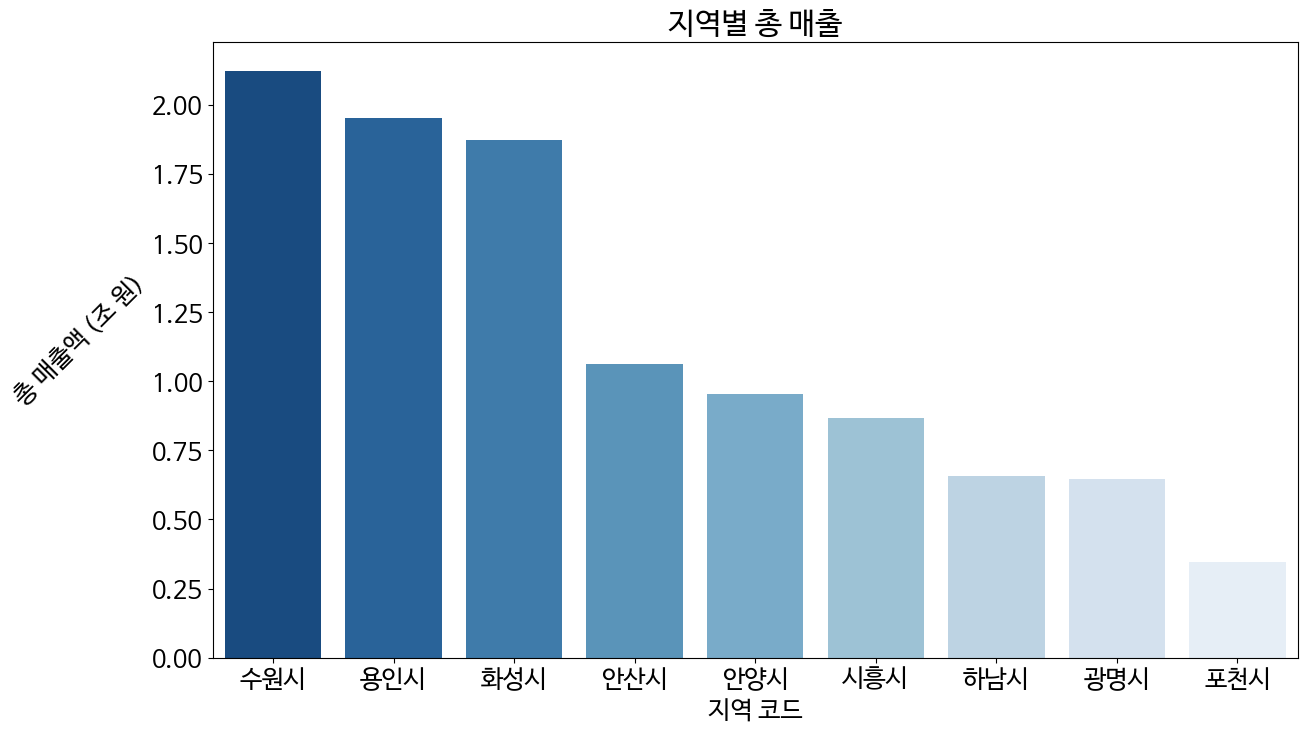

In [235]:
# 1. 지역별 매출 규모

region_amt = df.groupby('city')['amt'].sum().nlargest(10).reset_index()
region_amt['city'] = region_amt['city'].astype(str)
region_amt['amt_tril'] = region_amt['amt'] / 1e12 

plt.figure(figsize=(14, 8))
sns.barplot(data=region_amt, x='city', y='amt_tril', palette='Blues_r')
plt.title('지역별 총 매출')
plt.xlabel('지역 코드')
plt.ylabel('총 매출액 (조 원)', rotation=45, labelpad=45)
plt.show()

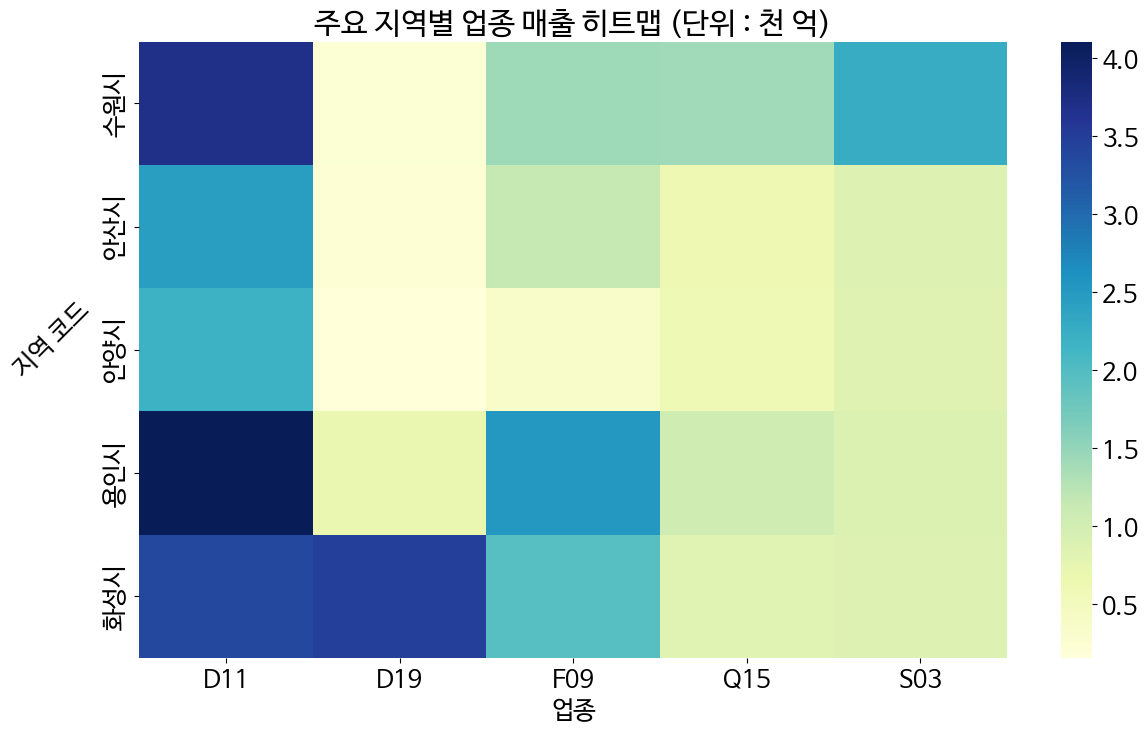

In [236]:
# 2. 지역 - 업종 분석 히트맵

top_5_regions = region_amt['city'][:5]

top_5_biz = df.groupby('card_tpbuz_cd', observed=True)['amt'].sum().nlargest(5).index

subset = df[(df['city'].isin(top_5_regions)) & (df['card_tpbuz_cd'].isin(top_5_biz))]

subset['amt_100bil'] = subset['amt'] / 1e11 

pivot = subset.groupby(['city', 'card_tpbuz_cd'], observed=True)['amt_100bil'].sum().unstack()

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, cmap='YlGnBu', annot=False)
plt.title('주요 지역별 업종 매출 히트맵 (단위 : 천 억)')
plt.xlabel('업종')
plt.ylabel('지역 코드', rotation=45, labelpad=30)
plt.show()

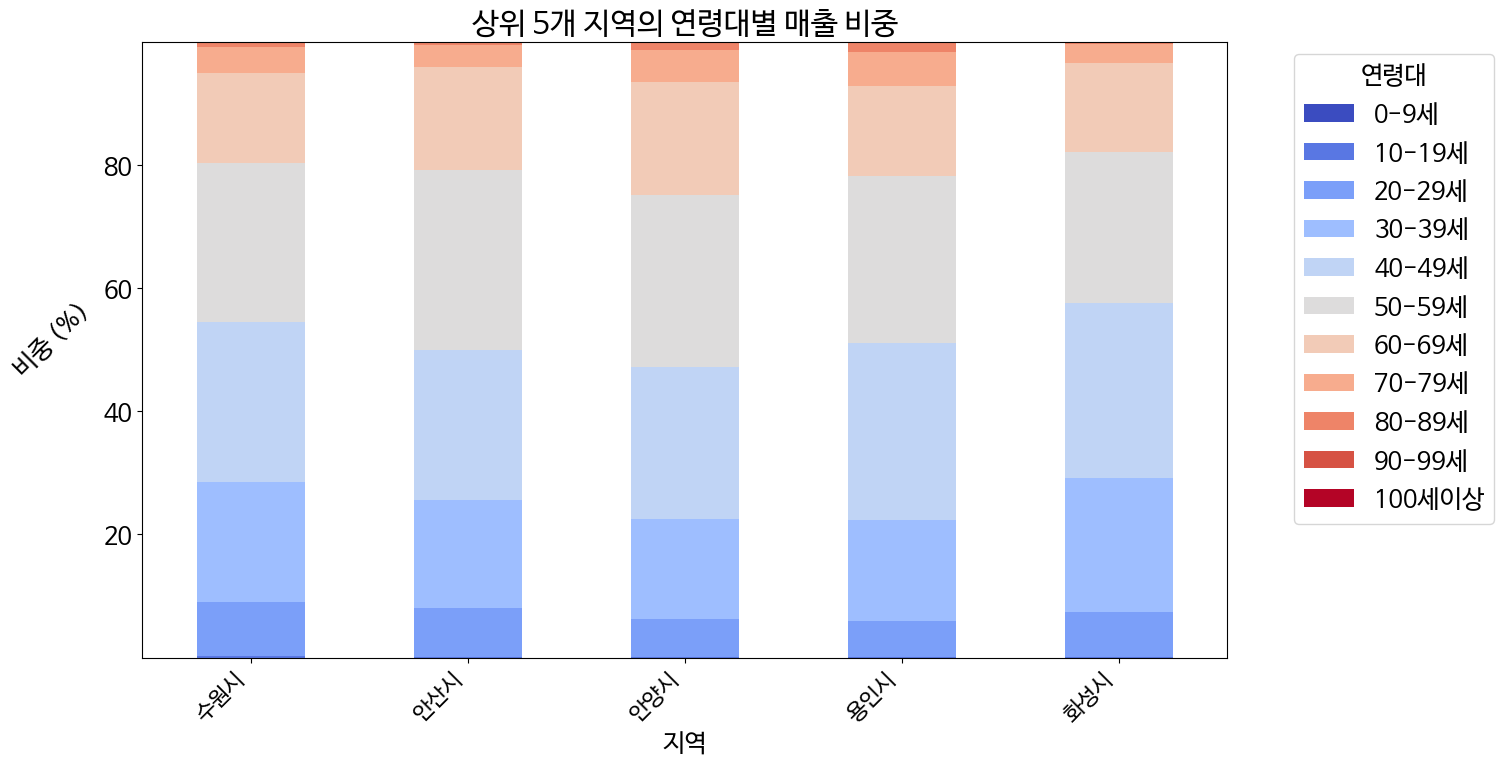

In [237]:
# 3. 지역별 연령대 분포
pivot_age = subset.groupby(['city', 'age'])['amt'].sum().unstack()
pivot_age = pivot_age.reindex(columns=age_order)
ratio_age = pivot_age.div(pivot_age.sum(axis=1), axis=0) * 100

ratio_age.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='coolwarm')
plt.title('상위 5개 지역의 연령대별 매출 비중')
plt.xlabel('지역')
plt.ylabel('비중 (%)', rotation=45, labelpad=30)
plt.legend(title='연령대', bbox_to_anchor=(1.05, 1))
plt.xticks(fontsize=16, rotation=45, ha='right')
plt.show()

## Step 6. 복합 상관관계 분석

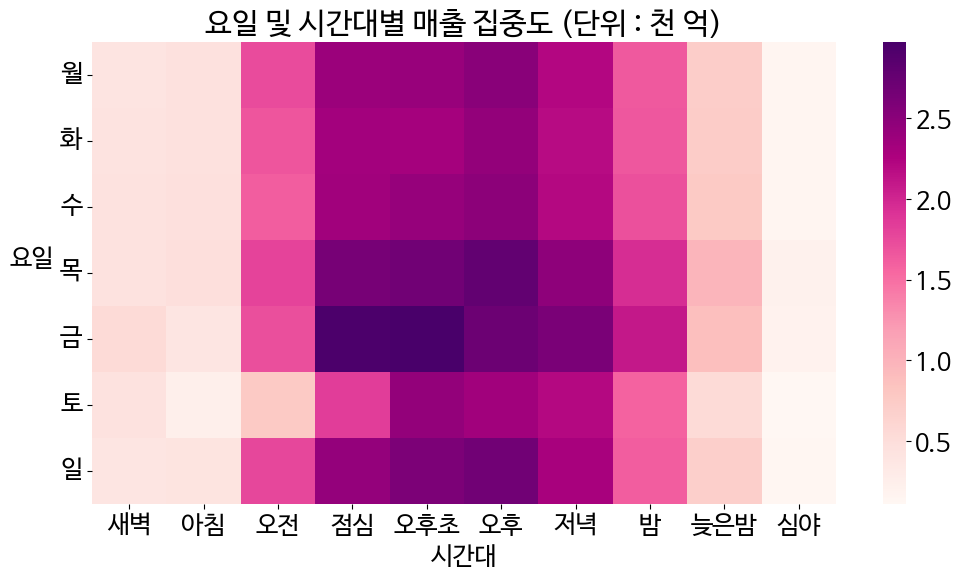

In [238]:
#  1. 요일 - 시간대 매출 히트맵
pivot_time = df.groupby(['day', 'hour'])['amt'].sum().unstack()
pivot_time = pivot_time.reindex(day_order)
pivot_time = pivot_time.reindex(columns=hour_order)
pivot_time = pivot_time / 1e11 

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_time, cmap='RdPu', annot=False)
plt.title('요일 및 시간대별 매출 집중도 (단위 : 천 억)')
plt.xlabel('시간대')
plt.ylabel('요일', rotation=0, labelpad=20)
plt.yticks(rotation=0)
plt.show()

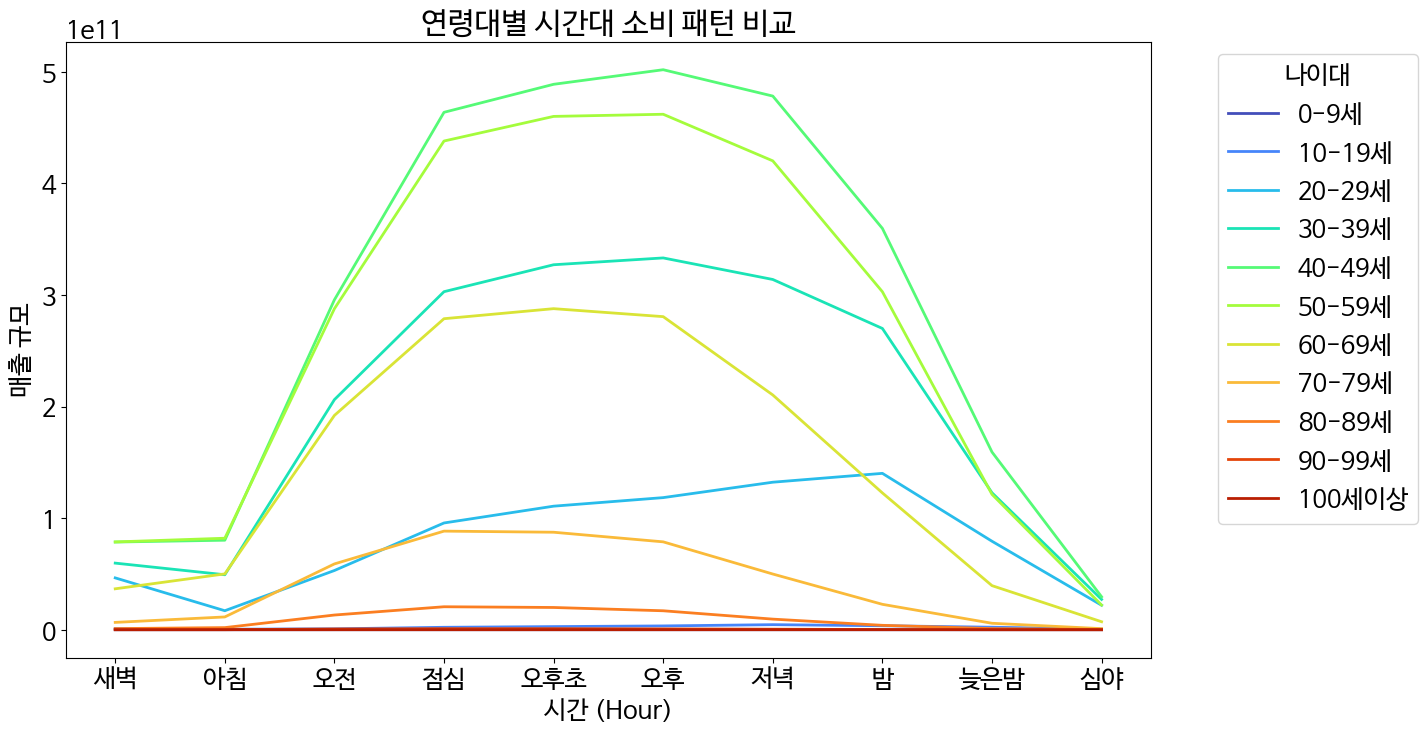

In [239]:
# 2. 연령대 - 시간대 활동 패턴 Line Chart

age_hour = df.groupby(['age', 'hour'])['amt'].sum().reset_index()
age_hour['age'] = pd.Categorical(age_hour['age'], categories=age_order, ordered=True)
age_hour['hour'] = pd.Categorical(age_hour['hour'], categories=hour_order, ordered=True)
age_hour = age_hour.sort_values('age').reset_index(drop=True)
age_hour = age_hour.sort_values('hour').reset_index(drop=True)


plt.figure(figsize=(14, 8))
sns.lineplot(data=age_hour, x='hour', y='amt', hue='age', palette='turbo', linewidth=2)
plt.title('연령대별 시간대 소비 패턴 비교')
plt.xlabel('시간 (Hour)')
plt.ylabel('매출 규모')
plt.legend(bbox_to_anchor=(1.05, 1), title='나이대')
plt.show()

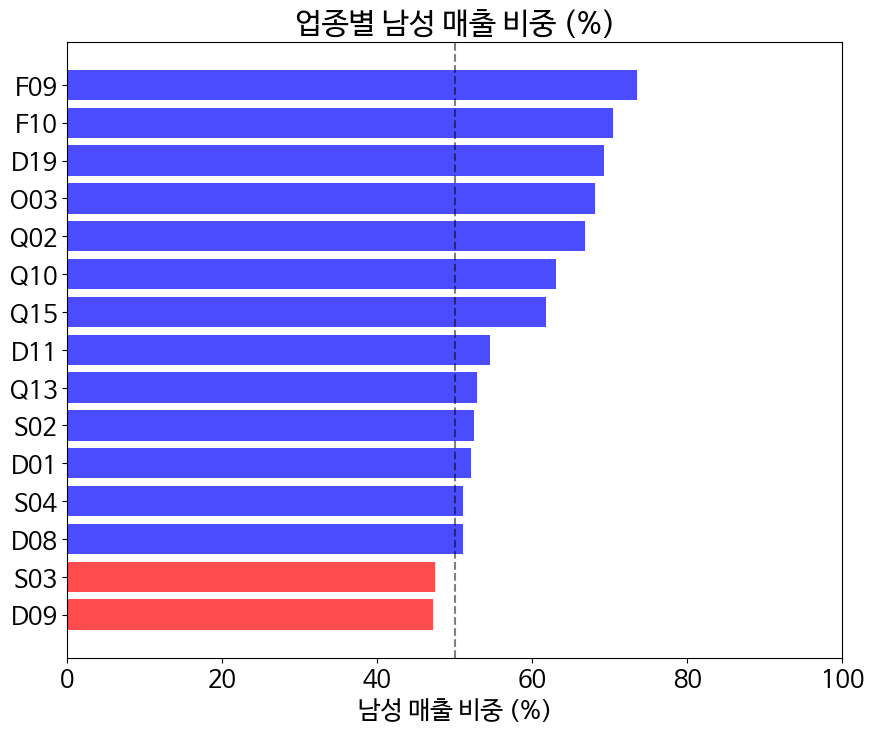

In [240]:
# 3. 성별 - 업종 선호도 격차

top_15_biz = df.groupby('card_tpbuz_cd', observed=True)['amt'].sum().nlargest(15).index
subset_sex = df[df['card_tpbuz_cd'].isin(top_15_biz)]

sex_biz = subset_sex.groupby(['card_tpbuz_cd', 'sex'], observed=True)['amt'].sum().unstack()
sex_biz['male_ratio'] = sex_biz['M'] / (sex_biz['M'] + sex_biz['F']) * 100
sex_biz = sex_biz.sort_values('male_ratio')

plt.figure(figsize=(10, 8))
plt.axvline(50, color='black', linestyle='--', alpha=0.5)
colors = ['blue' if x > 50 else 'red' for x in sex_biz['male_ratio']]
plt.barh(sex_biz.index, sex_biz['male_ratio'], color=colors, alpha=0.7)

plt.title('업종별 남성 매출 비중 (%)')
plt.xlabel('남성 매출 비중 (%)')
plt.xlim(0, 100)
plt.show()

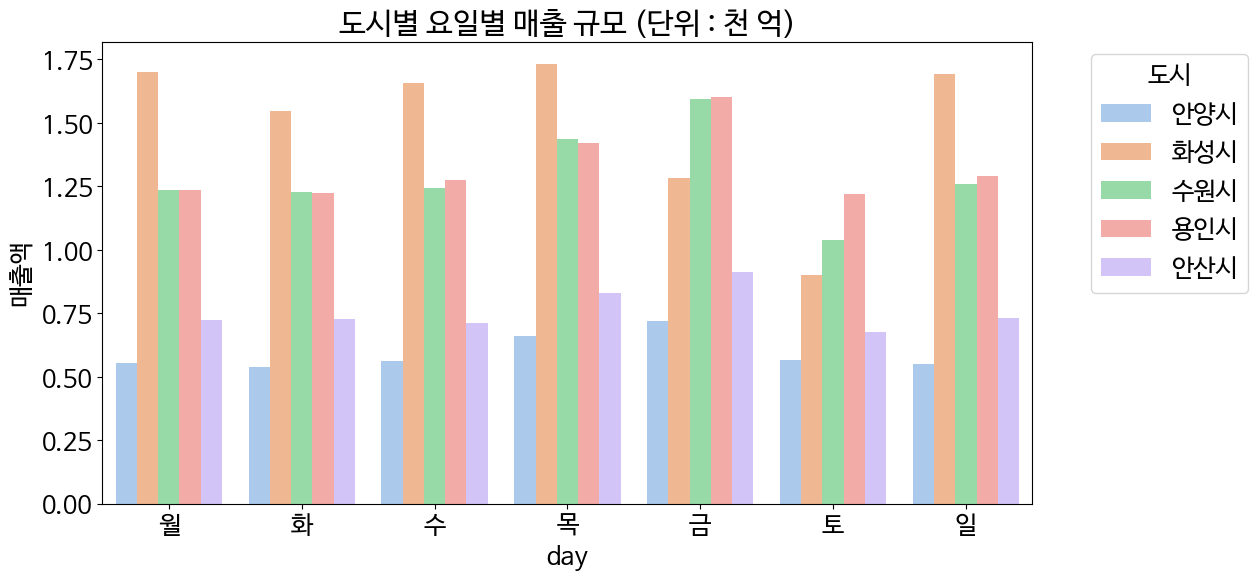

In [242]:
# 4. 도시 - 요일별 소비 트렌드
city_day = subset.groupby(['city', 'day'])['amt'].sum().reset_index()
city_day['day'] = pd.Categorical(city_day['day'], categories=day_order, ordered=True)
city_day = city_day.sort_values('day')
city_day['amt_scaled'] = city_day['amt'] / 1e11

plt.figure(figsize=(12, 6))
sns.barplot(data=city_day, x='day', y='amt_scaled', hue='city', palette='pastel')
plt.title('도시별 요일별 매출 규모 (단위 : 천 억)')
plt.ylabel('매출액')
plt.legend(title='도시', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()